In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.manifold import TSNE

# Head and Neck Squamous Clustering with Skin Tissue

In [124]:
def get_label(df):
    labels = []
    for sample in df.columns:
        if 'GTEX-' in sample:
            labels.append(0)
        elif sample.endswith('01'):
            labels.append(1)
        elif sample.endswith('11'):
            labels.append(2)
        else:
            labels.append(3)
    return np.array(labels)

def plot_dimensionality_reduction(ax, x, label, title, alpha=0.5):
    names = ['GTEX', 'Head_and_Neck', 'Melanoma']
    length = [0, 1, 2]
    cm = plt.get_cmap('Accent')
    color_set = (cm(1. * i / len(names)) for i in xrange(len(names)))
    for color, i, target_name in zip(color_set, length, names):
        ax.scatter(x[label == i, 0], x[label == i, 1], alpha=alpha, color=color, label=target_name)
    ax.legend(loc='best', fontsize=6)
    ax.set_title(title)
    
def run_tsne(df):
    model = TSNE(n_components=2)
    return model.fit_transform(np.array(df))

def find_protein_coding_genes(gencode_path):
    pc_genes = set()
    with open(gencode_path, 'r') as f:
        for line in f.readlines():
            if not line.startswith('#'):
                line = line.split()
                if line[line.index('gene_type') + 1] == '"protein_coding";':
                    pc_genes.add(line[line.index('gene_id') + 1].split('"')[1])
    return list(pc_genes)


def remove_nonprotein_coding_genes(df, pc_genes):
    return df.ix[pc_genes]

def pop_missing(gene_set, df):
    for sample in list(gene_set):
        if sample not in df.columns:
            gene_set.remove(sample)
    return set(gene_set)

### Metadata

In [8]:
meta = pd.read_csv('tcga-summary.tsv', sep='\t')

In [47]:
meta.disease_name.value_counts()

Breast invasive carcinoma                                           2510
Kidney renal clear cell carcinoma                                   1678
Stomach adenocarcinoma                                              1674
Ovarian serous cystadenocarcinoma                                   1579
Uterine Corpus Endometrioid Carcinoma                               1511
Colon adenocarcinoma                                                1303
Lung adenocarcinoma                                                 1222
Thyroid carcinoma                                                   1144
Head and Neck squamous cell carcinoma                               1132
Prostate adenocarcinoma                                             1116
Lung squamous cell carcinoma                                        1108
Brain Lower Grade Glioma                                            1066
Skin Cutaneous Melanoma                                              946
Bladder Urothelial Carcinoma                       

In [44]:
hn = set(x[:15] for x in meta[meta.disease_name == 'Head and Neck squamous cell carcinoma'].barcode)
sm = set(x[:15] for x in meta[meta.disease_name == 'Skin Cutaneous Melanoma'].barcode)

### Counts 

In [2]:
df = pd.read_csv('tcga_gene_counts', index_col=0, sep='\t')

Collect protein coding genes and subset

In [52]:
pc_genes = find_protein_coding_genes('gencode.v23.annotation.gtf')

In [53]:
df = remove_nonprotein_coding_genes(df, pc_genes)

In [74]:
df = df.apply(lambda y: np.log(y+1))

### TCGA Comparison

Remove samples missing from TCGA table

In [70]:
hn = pop_missing(hn, df)
sm = pop_missing(sm, df)

In [71]:
tcga_df = df[list(hn) + list(sm)]

In [120]:
labels = np.array([0] * len(hn) + [1] * len(sm))

### Run T-SNE

In [113]:
x = run_tsne(tcga_df.T)

### Plot

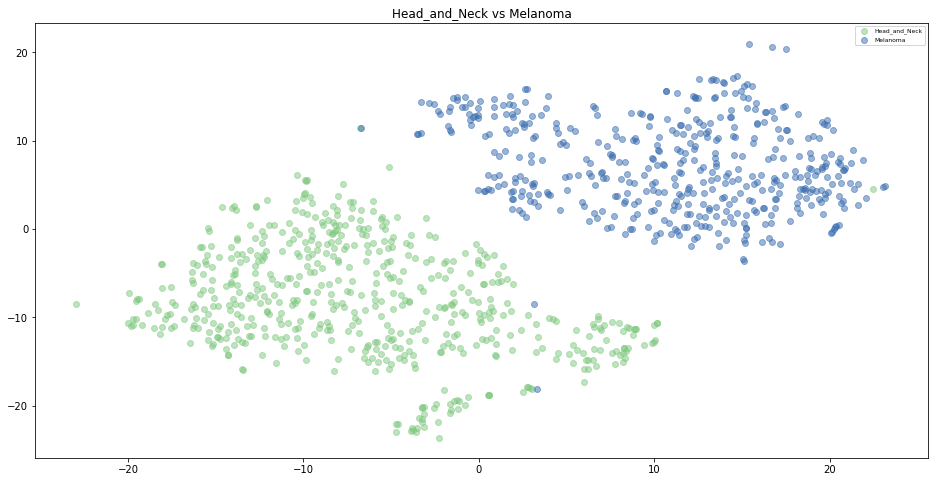

In [123]:
f, ax = plt.subplots(figsize=(16,8))
plot_dimensionality_reduction(ax=ax, x=x, label=labels, title='Head_and_Neck vs Melanoma')

### GTEx

In [94]:
gtex = pd.read_csv('combined-gtex-tcga-counts-protein-coding.tsv', index_col=0, sep='\t')

In [95]:
gtex = gtex[ [x for x in gtex.columns if 'GTEX-' in x]]

In [100]:
combined = pd.concat([gtex, tcga_df], axis=1)

In [125]:
labels = np.array( [0] * len(gtex.columns) + [1] * len(hn) + [2] * len(sm) )

In [126]:
x = run_tsne(combined.T)

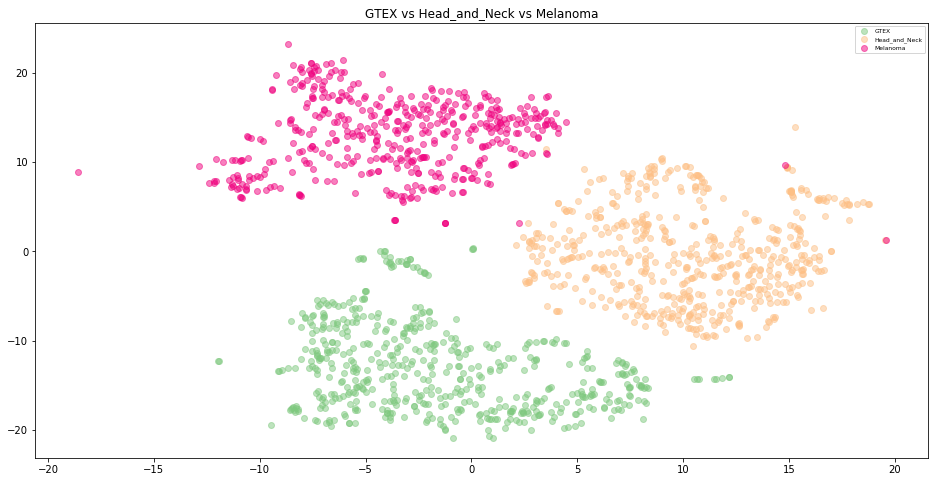

In [127]:
f, ax = plt.subplots(figsize=(16,8))
plot_dimensionality_reduction(ax=ax, x=x, label=labels, title='GTEX vs Head_and_Neck vs Melanoma')